# Making Markov Chains of Various Types

First we'll load the full list of pickled sequences *(this may take a moment or two)*.

In [1]:
import pickle

In [2]:
with open('all_melodies.pkl', 'r') as f:
    all_melodies = pickle.load(f)
with open('all_rhythms.pkl', 'r') as g:
    all_rhythms = pickle.load(g)

In [3]:
assert len(all_melodies) == len(all_rhythms)

Next, we'll define a **Markov** object that will store Markov chain information for chains of various orders and types.

In [4]:
class Markov(object):
    """A container for holding Markov chains of various orders, 
    where the events in the given 'current state' may occur temporally 
    before and/or after the note to be examined as the 'next state'.
    """
    
    def __init__(self, before = 0, after = 0, mode = 0):
        """Initialize a Markov object with `before` notes before the
        space to be filled, `after` notes after the space to be filled,
        and with `mode` equal to 0, 1 or 2 according to whether the 'current
        state' contains notes only before, only after, or both before and after
        the note to be filled in the 'next state'.
        
        Inputs: 
        before - int - number of notes before next state
        after - int - number of notes after next state
        mode - int in range(3) - mode of the chain(see above)
        
        Outputs - Markov object
        """
        
        if mode == 0:
            assert before != 0 and after == 0
        elif mode == 1:
            assert before == 0 and after != 0
        else:
            assert before != 0 and after != 0

        self.before = before
        self.after = after
        self.mode = mode
        self.state_dict = {}
        
    def add_data(self, seq, result):
        """Add one (current state -> next state) instance to the dictionary.
        Store each instance as a tally, to be normalized later.
        
        Inputs:
        seq - if mode = 0, seq is a tuple of length before
              if mode = 1, seq is a tuple of length after
              if mode = 2, seq is a list of length two, with first element
                           a tuple of length before and with second element
                           a tuple of length after
        result - int - single event
        
        Outputs:
        None
        """
        
        if self.mode == 0:
            assert isinstance(seq, tuple) and len(seq) == self.before
        elif self.mode == 1:
            assert isinstance(seq, tuple) and len(seq) == self.after
        else:
            assert (isinstance(seq, tuple) and len(seq) == 2 and
                    isinstance(seq[0], tuple) and len(seq[0]) == self.before and
                    isinstance(seq[1], tuple) and len(seq[1]) == self.after)
            
        if seq not in self.state_dict:
            self.state_dict[seq] = {result: 1}
        elif result in self.state_dict[seq]:
            self.state_dict[seq][result] += 1
        else:
            self.state_dict[seq][result] = 1
            
    def normalize(self):
        """Convert the state_dict dictionary from counts to probabilities.
        
        Inputs: None
        
        Outputs: None
        """
        
        for seq in self.state_dict:
            sum = 0
            for result in self.state_dict[seq]:
                sum += self.state_dict[seq][result]
            for result in self.state_dict[seq]:
                self.state_dict[seq][result] /= float(sum)
        
            

For our purposes, we want to consider chords as representing all N notes in the chord equally. For example, if a chord of three simultaneous note occurs as a 'next state', we will count each of the three component notes of that chord as equally likely to occur after the given 'current state'. 

In order to use `itertools.product` on the slice of the sequence we are looking for, we'll convert *all* the integer events to singleton lists.

In [7]:
for melody in all_melodies:
    for i in range(len(melody)):
        if isinstance(melody[i], int):
            melody[i] = [melody[i]]

In [8]:
print all_melodies[0]

[[72], [73], [75], [68], [73], [76], [68], [73], [68], [71], [76], [68], [71], [68], [70], [76], [68], [70], [70], [73], [78], [70], [73], [65], [58], [60], [62]]


This is the main function used to actually extract current and next states from a raw sequence.

In [9]:
import itertools

def iterate_melody(mel, mark, before, after):
    """Adds one new observation to the Markov chain training process.
    
    Inputs: 
    mel - a list of lists representing a melody sequence
    mark - a Markov object
    before - integer, how many notes before next state
    after - integer, how many notes after next state
    
    Outputs:
    None (instead adds data to markov object directly)
    """
    
    full_length = before + after + 1
    for i in range(len(mel) - full_length):
        for seq in itertools.product(*mel[i:i + full_length]):
            before_seq, after_seq, val = seq[:before], seq[-after:], seq[before]
            mode = mark.mode
            if mode == 0:
                mark.add_data(before_seq, val)
            elif mode == 1:
                mark.add_data(after_seq, val)
            else:
                mark.add_data((before_seq, after_seq), val)

Here is the general implementation for turning a sequence into a Markov dictionary:

1. Create Markov object with the desired tail lengths
2. Call iterate_melody on the sequence
3. Normalize the Markov dictionaries

In [12]:
markov = Markov(1, 0, 0)
iterate_melody(all_melodies[0], markov, before = 1, after = 0)
markov.normalize()
print markov.state_dict

{(58,): {60: 1.0}, (65,): {58: 1.0}, (72,): {73: 1.0}, (73,): {68: 0.2, 75: 0.2, 76: 0.2, 78: 0.2, 65: 0.2}, (68,): {73: 0.3333333333333333, 70: 0.3333333333333333, 71: 0.3333333333333333}, (75,): {68: 1.0}, (70,): {73: 0.5, 76: 0.25, 70: 0.25}, (76,): {68: 1.0}, (71,): {68: 0.5, 76: 0.5}, (78,): {70: 1.0}}


In [13]:
markov = Markov(2, 0, 0)
iterate_melody(all_melodies[0], markov, before = 2, after = 0)
markov.normalize()
print markov.state_dict

{(71, 68): {70: 1.0}, (68, 71): {68: 0.5, 76: 0.5}, (76, 68): {73: 0.3333333333333333, 70: 0.3333333333333333, 71: 0.3333333333333333}, (68, 73): {68: 0.5, 76: 0.5}, (68, 70): {76: 0.5, 70: 0.5}, (70, 70): {73: 1.0}, (71, 76): {68: 1.0}, (70, 73): {65: 0.5, 78: 0.5}, (78, 70): {73: 1.0}, (72, 73): {75: 1.0}, (65, 58): {60: 1.0}, (73, 75): {68: 1.0}, (73, 68): {71: 1.0}, (70, 76): {68: 1.0}, (75, 68): {73: 1.0}, (73, 78): {70: 1.0}, (73, 76): {68: 1.0}, (73, 65): {58: 1.0}}


Sanity check:

In [14]:
print all_melodies[0]

[[72], [73], [75], [68], [73], [76], [68], [73], [68], [71], [76], [68], [71], [68], [70], [76], [68], [70], [70], [73], [78], [70], [73], [65], [58], [60], [62]]


The counts seem to be right (but certainly check them yourselves if you don't believe me!).

Testing out all different modes:

In [16]:
markov = Markov(0, 1, 1)
iterate_melody(all_melodies[0], markov, before = 0, after = 1)
markov.normalize()
print markov.state_dict

{(58,): {65: 1.0}, (65,): {73: 1.0}, (60,): {58: 1.0}, (73,): {72: 0.2, 68: 0.4, 70: 0.4}, (68,): {73: 0.16666666666666666, 75: 0.16666666666666666, 76: 0.5, 71: 0.16666666666666666}, (75,): {73: 1.0}, (70,): {68: 0.5, 78: 0.25, 70: 0.25}, (76,): {73: 0.3333333333333333, 70: 0.3333333333333333, 71: 0.3333333333333333}, (71,): {68: 1.0}, (78,): {73: 1.0}}


In [17]:
markov = Markov(2, 2, 2)
iterate_melody(all_melodies[0], markov, before = 2, after = 2)
markov.normalize()
print markov.state_dict

{((75, 68), (76, 68)): {73: 1.0}, ((73, 78), (73, 65)): {70: 1.0}, ((70, 76), (70, 70)): {68: 1.0}, ((68, 73), (71, 76)): {68: 1.0}, ((71, 68), (76, 68)): {70: 1.0}, ((73, 76), (73, 68)): {68: 1.0}, ((71, 76), (71, 68)): {68: 1.0}, ((72, 73), (68, 73)): {75: 1.0}, ((76, 68), (68, 71)): {73: 1.0}, ((76, 68), (70, 73)): {70: 1.0}, ((78, 70), (65, 58)): {73: 1.0}, ((68, 71), (70, 76)): {68: 1.0}, ((68, 71), (68, 71)): {76: 1.0}, ((73, 75), (73, 76)): {68: 1.0}, ((70, 73), (70, 73)): {78: 1.0}, ((70, 70), (78, 70)): {73: 1.0}, ((68, 70), (73, 78)): {70: 1.0}, ((68, 70), (68, 70)): {76: 1.0}, ((68, 73), (68, 73)): {76: 1.0}, ((76, 68), (68, 70)): {71: 1.0}, ((73, 68), (76, 68)): {71: 1.0}, ((70, 73), (58, 60)): {65: 1.0}}


This seems to work pretty well for melodies! 

In [15]:
with open('all_melodies.pkl', 'w') as f:
    pickle.dump(all_melodies, f)

Let's see what happens when we train a Markov chain on ALL the melodies in our corpus.

In [18]:
mark_a = Markov(1, 0, 0)
for i in range(len(all_melodies)):
    iterate_melody(all_melodies[i], mark_a, before = 1, after = 0)

In [20]:
mark_a.normalize()
for key in mark_a.state_dict.keys()[:2]:
    print key, mark_a.state_dict[key]

(32,) {13: 1.3626020248266096e-05, 14: 1.3626020248266096e-05, 16: 8.175612148959658e-05, 17: 1.3626020248266096e-05, 18: 6.131709111719744e-05, 19: 3.4065050620665245e-05, 20: 0.0014852362070610046, 21: 4.769107086893134e-05, 22: 0.0006336099415443734, 23: 0.00044284565806864816, 24: 0.0005246017795582448, 25: 0.007616945318780748, 26: 0.009817547588875722, 27: 0.0191104933981932, 28: 0.012297483274060153, 29: 0.016208151085312525, 30: 0.03929062938587529, 31: 0.036715311558952995, 32: 0.40460423224188935, 33: 0.06311572578996856, 34: 0.06838218261592341, 35: 0.03385384730681712, 36: 0.021372412759405372, 37: 0.042996906893403665, 38: 0.008509449645042178, 39: 0.033404188638624335, 40: 0.005722928504271761, 41: 0.003011350474866807, 42: 0.005491286160051238, 43: 0.0023164234422052366, 44: 0.08025044625216317, 45: 0.007821335622504741, 46: 0.00507569254247912, 47: 0.0015261142678058028, 48: 0.001260406872964614, 49: 0.0012944719235852792, 50: 0.000565479840303043, 51: 0.006976522367112

As you can see, the note '32' is followed by a large variety of other notes throughout the corpus. As such, the probability of any one such note is pretty slim, compared to the toy examples above. Let's see what the most likely notes are ...

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

<Container object of 91 artists>

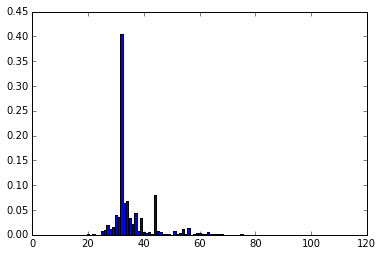

In [32]:
key = mark_a.state_dict.keys()[0]
D = mark_a.state_dict[key]

plt.bar(D.keys(), D.values(), align='center')

This seems like it would be pretty typical, a normal looking density centered around the note 32 itself, with an outlier second mode exactly one octave up, and a bit of a longer tail on the right side, where there is more room to have a tail. Cool!

In [33]:
with open('mark100.pkl', 'w') as f:
    pickle.dump(mark_a, f)

Note that this pickled file of 'counts' is much smaller (245K) than the collection of pickled sequences (~500M).

In [ ]:
##DANGER: THIS LOOP CRASHES KERNEL AT THIS STAGE
"""
for before in range(4):
    for after in range(4):
        if before == 0:
            if after == 0:
                continue
            mode = 1
        elif after == 0:
            mode = 0
        else:
            mode = 2
        mark = Markov(before, after, mode)
        for k in range(len(all_melodies)):
            iterate_melody(all_melodies[k], mark, before = before, after = after)
        mark.normalize()
        with open('markov' + str(before) + str(after) + str(mode) + '.pkl', 'w') as f:
            pickle.dump(mark, f)
"""

As it turns out, this way of storing the information isn't great either; with Markov chains of order >= 4, the kernel crashed!

One thing left to ponder is how **absolutely** we want to represent note position in these chains. For example, is the sequence C-D-E pretty much equivalent to the sequence G-A-B? Can we count them as one? And if so, will this improve the runtime for these training steps?